In [2]:
import pickle
import flask
import numpy as np
import pandas as pd
from numpy import linalg as LA
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn import metrics

In [3]:
train_df_bow = pd.read_json('../data/train/trainText-75-25-bow.json', lines=True)
test_df_bow = pd.read_json('../data/test/testText-75-25-bow.json', lines=True)

In [4]:
X_test_bow = list(test_df_bow['recipe'])
y_test_bow = list(test_df_bow['cuisine'])

In [5]:
#eval prep
vectors = pickle.load(open("../data/data.p", "rb"))
string_names = ['italian', 'mexican', 'southern_us', 'indian', 'chinese', 'french', 'cajun_creole',
                'thai', 'japanese', 'greek', 'spanish', 'korean', 'vietnamese', 'moroccan', 'british', 
                'filipino', 'irish', 'jamaican', 'russian', 'brazilian']

count_dict = {}
total_dict = {}
average_dict = {}
features = len(vectors[0]['vector'])

for string in string_names:
    if string not in average_dict:
        average_dict[string] = ([0] * features)
        total_dict[string] = ([0] * features)
    if string not in count_dict:
        count_dict[string] = 0

for recipe in vectors:
    total_dict[recipe['cuisine']] += recipe['vector']
    count_dict[recipe['cuisine']] += 1

for cuisine, average_arr in average_dict.items():
    average_dict[cuisine] = total_dict[cuisine]/count_dict[cuisine]

FileNotFoundError: [Errno 2] No such file or directory: '../data/data.p'

In [ ]:
# Initialization of Global Variables
cuisine_to_ingredients = average_dict
n_cuisines = len(cuisine_to_ingredients.keys())
cuisine_types = sorted(list(cuisine_to_ingredients.keys()))

# Create Similarity Matrix
def create_sim_mat(sim_method, n_cuis, cuis_types, cuis_to_ingred):
    """Returns a numpy array of shape n_cuisines by n_cuisines such that the 
    entry (i,j) indicates the similarity between cuisines i and j.
    
    Note: Diagonals are set to 0.0.
    
    Params: {sim_method: Function (of some similarity measure),
             n_cuis: Integer,
             cuis_types: List,
             cuis_to_ingred: Dict}
    Returns: Numpy array
    """
    matrix = np.zeros((n_cuis,n_cuis))
    for x in range(0,n_cuis):
        for y in range(0,n_cuis):
            if x == y:
                matrix[x,y] = 0.0
            else:
                matrix[x,y] = sim_method(cuis_types[x], cuis_types[y], cuis_to_ingred)
    return matrix

## Minkowski Distance (CURRENTLY NOT USED)

The Minkowski distance is a generalized form of the Euclidean distance (if p=2) and the Manhattan distance (if p=1).

$ \left(\sum_{i=1}^n |x_i-y_i|^p\right)^{1/p} $

Set exponent to 1 or 2 for Euclidean or Manhattan, or otherwise for Minkowski
exp = 1

def minkowski(cuis1, cuis2, cuis_to_ingred, p):
    """Returns a float giving similarity based on Minkowski Distance of 
       the two cuisine types.
    
    Params: {cuis1: String,
             cuis2: String,
             cuis_to_ingred: Dict
             p: Integer}
    Returns: Float (Jaccard similarity of the two cuisine types.)
    """
    cuisine1 = cuis_to_ingred[cuis1]
    cuisine2 = cuis_to_ingred[cuis2]
    distance = 0.0
    for i in range(0,len(cuisine1)):
        distance = distance + ((cuisine1[i]-cuisine2[i])**p)**(1.0/p)
    sim = 1/distance
    return sim

#Plot Heatmap of Simliarity Matrix
distance_sim_matrix = create_sim_mat(minkowski, n_cuisines, cuisine_types, cuisine_to_ingredients, exp)
plt.imshow(distance_sim_matrix, interpolation='none',
           cmap=plt.cm.Greys)
plt.colorbar()

plt.xticks(range(n_cuisines), cuisine_types, rotation=90)
plt.yticks(range(n_cuisines), cuisine_types)
plt.show()

## Jaccard Similarity

$ J(A, B) = \frac{|A \cap B|}{|A \cup B|} $

In this case,

$ J(A, B) = \frac{\sum_{x \in \text{ingredients}} x \in A \,\text{and}\, x \in B}
{\sum_{x \in \text{ingredients}}x \in A \,\text{or}\, x \in B} $

In [6]:
def jaccard(cuis1, cuis2, cuis_to_ingred):
    """Returns a float giving the Jaccard similarity of 
       the two cuisine types.
    
    Params: {cuis1: String,
             cuis2: String,
             cuis_to_ingred: Dict}
    Returns: Float (Jaccard similarity of the two cuisine types.)
    """
    cuisine1 = cuis_to_ingred[cuis1]
    cuisine2 = cuis_to_ingred[cuis2]

    j_and, j_or = 0.0,0.0
    for i in range(0,len(cuisine1)):
        if (cuisine1[i]>0) and (cuisine2[i]>0):
            j_and += 1.0
            j_or += 1.0
        elif (cuisine1[i]>0) or (cuisine2[i]>0):
            j_or += 1.0
    j_sim = j_and/j_or
    return j_sim

In [7]:
# Plot Heatmap of Simliarity Matrix
j_sim_matrix = create_sim_mat(jaccard, n_cuisines, cuisine_types, cuisine_to_ingredients)
plt.imshow(j_sim_matrix, interpolation='none',
           cmap=plt.cm.Greys)
plt.colorbar()

plt.xticks(range(n_cuisines), cuisine_types, rotation=90)
plt.yticks(range(n_cuisines), cuisine_types)
plt.show()

NameError: name 'create_sim_mat' is not defined

## Generalized Jaccard Similarity

The similarity measure that we took above doesn't take into account how often each ingredient appears in recipes with a certain cuisine label. To account for this, we can use Generalized Jaccard, an extension of Jaccard to weighted sets.

For each ingredient $x$ and each cuisine $C$, we compute the frequency weight $\text{tf}(x, C)$ as the ratio between the number of times recipes with label $C$ contains $x$, and the total number of ingredients used in $C$.

Generalized Jaccard is:

$ GJ(A, B) = \frac{\sum_{x \in \text{ingredients}} \text{min}(\text{tf}(x, A), \text{tf}(x, B))}
{\sum_{x \in \text{ingredients}} \text{max}(\text{tf}(x, A), \text{tf}(x, B))} $

Note that Jaccard is equivalent to Generalized Jaccard if the weights are binarized by truncating all positive weights to 1.

In [8]:
def g_jaccard(cuis1, cuis2, cuis_to_ingred):
    """Returns a float giving the Generalized Jaccard similarity of 
       the two cuisine types.
    
    Params: {cuis1: String,
             cuis2: String,
             cuis_to_ingred: Dict}
    Returns: Float (Generalized Jaccard similarity of the two cuisine types.)
    """
    cuisine1 = cuis_to_ingred[cuis1]
    cuisine2 = cuis_to_ingred[cuis2]
    den1 = float(np.sum(cuisine1))
    den2 = float(np.sum(cuisine2))

    gj_num, gj_den = 0.0,0.0
    for i in range(0,len(cuisine1)):
        tf1 = float(cuisine1[i])/den1
        tf2 = float(cuisine2[i])/den2
        gj_num += min(tf1, tf2)
        gj_den += max(tf1, tf2)
    gj_sim = gj_num/gj_den
    return gj_sim

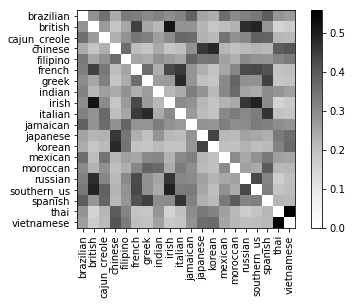

In [9]:
# Plot Heatmap of Simliarity Matrix
gj_sim_matrix = create_sim_mat(g_jaccard, n_cuisines, cuisine_types, cuisine_to_ingredients)
plt.imshow(gj_sim_matrix, interpolation='none',
           cmap=plt.cm.Greys)
plt.colorbar()

plt.xticks(range(n_cuisines), cuisine_types, rotation=90)
plt.yticks(range(n_cuisines), cuisine_types)
plt.show()

## Cosine Similarity

$ cossim(\vec{a}, \vec{b}) = \frac{\vec{a} \cdot \vec{b}}{\|\vec{a}\| \cdot \|\vec{b}\|}$

Specifically, focusing on the numerator...

$ \vec{a} \cdot \vec{b} = \sum_{i} {a_i} * {b_i} $

In [10]:
def cossim(cuis1, cuis2, cuis_to_ingred):
    """Returns a float giving the Cosine similarity of 
       the two cuisine types.
    
    Params: {cuis1: String,
             cuis2: String,
             cuis_to_ingred: Dict}
    Returns: Float (Cosine similarity of the two cuisine types.)
    """
    cuisine1 = cuis_to_ingred[cuis1]
    cuisine2 = cuis_to_ingred[cuis2]
    cos_sim = (cuisine1*cuisine2).sum()
    #with denominator (consideration of vector magnitudes)
    cuis1_mag = LA.norm(cuisine1)
    cuis2_mag = LA.norm(cuisine2)
    cos_sim = cos_sim/(cuis1_mag*cuis2_mag)
    return cos_sim

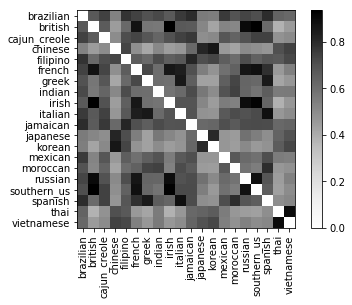

In [11]:
# Plot Heatmap of Simliarity Matrix
cos_sim_matrix = create_sim_mat(cossim, n_cuisines, cuisine_types, cuisine_to_ingredients)
plt.imshow(cos_sim_matrix, interpolation='none',
           cmap=plt.cm.Greys)
plt.colorbar()

plt.xticks(range(n_cuisines), cuisine_types, rotation=90)
plt.yticks(range(n_cuisines), cuisine_types)
plt.show()

# Combining Similarity Matrices

In [12]:
test1 = 'thai'
test2 = 'vietnamese'
test_j = jaccard(test1, test2, cuisine_to_ingredients)
test_gj = g_jaccard(test1, test2, cuisine_to_ingredients)
test_cos = cossim(test1, test2, cuisine_to_ingredients)

print("Jaccard Similarity: " + test1 + " vs. " + test2)
print("============================================")
print("")

print("Jaccard Similarity: " + str(test_j))
print("--------------------")
print("")

print("Generalized Jaccard Similarity: " + str(test_gj))
print("--------------------")
print("")

print("Cosine Similarity: " + str(test_cos))
print("--------------------")
print("")

print("Combined Similarity: " + str((test_j+test_gj+test_cos)/3.0))
print("--------------------")
print("")

Jaccard Similarity: thai vs. vietnamese

Jaccard Similarity: 0.5630383711824589
--------------------

Generalized Jaccard Similarity: 0.5573996010524858
--------------------

Cosine Similarity: 0.897706328631
--------------------

Combined Similarity: 0.672714766955
--------------------



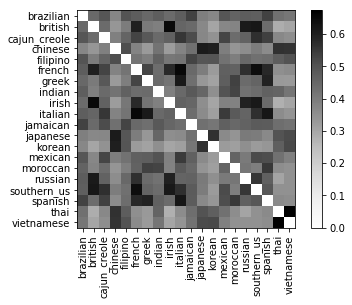

Average Similarity
0.44172032731


In [13]:
# Combining the 3 Simliarity Matrices
comb_sim_matrix = (j_sim_matrix + gj_sim_matrix + cos_sim_matrix)/3.0
plt.imshow(comb_sim_matrix, interpolation='none',
           cmap=plt.cm.Greys)
plt.colorbar()

plt.xticks(range(n_cuisines), cuisine_types, rotation=90)
plt.yticks(range(n_cuisines), cuisine_types)
plt.show()

# Average Similarity
print("Average Similarity")
print("===================")
avg_sim = comb_sim_matrix.sum()/(n_cuisines**2-n_cuisines)
print(avg_sim)

# Evaluation

In [14]:
# Build inverted index
def build_inv_idx(lst):
    """ Builds an inverted index.
    
    Params: {lst: List}
    Returns: Dict (an inverted index of cuisine types)
    """
    inverted_idx = {}
    for idx in range(0,len(lst)):
        inverted_idx[lst[idx]] = idx
    return inverted_idx

In [15]:
# Inverted Index for Cuisine Types
cuis_invidx = build_inv_idx(cuisine_types)
print(cuis_invidx)

{'brazilian': 0, 'british': 1, 'cajun_creole': 2, 'chinese': 3, 'filipino': 4, 'french': 5, 'greek': 6, 'indian': 7, 'irish': 8, 'italian': 9, 'jamaican': 10, 'japanese': 11, 'korean': 12, 'mexican': 13, 'moroccan': 14, 'russian': 15, 'southern_us': 16, 'spanish': 17, 'thai': 18, 'vietnamese': 19}


In [16]:
# EVALUATION
def eval(proba, test, sim_matrix, sim_cutoff):
    eval_scores = []
    eval_list = np.zeros(n_cuisines)
    counter_list = np.zeros(n_cuisines)
    for r in range(len(test)):
        score = 0
        actual = test[r]
        for c in range(n_cuisines):
            predicted = cuisine_types[c]
            similarity = sim_matrix[cuis_invidx[predicted], cuis_invidx[actual]]
            if similarity == 0.0:
                similarity = 1.0
            if similarity >= sim_cutoff:
                score += similarity*(proba[r,c])
        eval_list[cuis_invidx[actual]] += score
        counter_list[cuis_invidx[actual]] += 1
        eval_scores.append(score)
    for i in range(len(eval_list)):
        accuracy_list = np.divide(eval_list, counter_list)
    accuracy = sum(eval_scores) / len(eval_scores)
    return accuracy_list,accuracy

In [59]:
avg_sim_j = j_sim_matrix.sum()/(n_cuisines**2-n_cuisines)
avg_sim_gj = gj_sim_matrix.sum()/(n_cuisines**2-n_cuisines)
avg_sim_cos = cos_sim_matrix.sum()/(n_cuisines**2-n_cuisines)
avg_sim_comb = comb_sim_matrix.sum()/(n_cuisines**2-n_cuisines)
print("Average Similarity (Jaccard): " + str(avg_sim_j))
print("Average Similarity (Gen. Jaccard): " + str(avg_sim_gj))
print("Average Similarity (Cosine Sim): " + str(avg_sim_cos))
print("Average Similarity (Combined): " + str(avg_sim_comb))
  
def evaluation(proba):
    print('\t\tJaccard\t\tGen. Jaccard\tCosine Sim\tCombined Sim')
    print('------------------------------------------------------------------------------')
    for c in cuisine_types:
        j = str(round(eval(proba, y_test_bow, j_sim_matrix, avg_sim_j)[0][cuis_invidx[c]]*100,2)) + "%"
        gj = str(round(eval(proba, y_test_bow, gj_sim_matrix, avg_sim_gj)[0][cuis_invidx[c]]*100,2)) + "%"
        cos = str(round(eval(proba, y_test_bow, cos_sim_matrix, avg_sim_cos)[0][cuis_invidx[c]]*100,2)) + "%"
        comb = str(round(eval(proba, y_test_bow, comb_sim_matrix, avg_sim_comb)[0][cuis_invidx[c]]*100,2)) + "%"
        if len(c) < 7:
            print(c + ':\t\t' + j + '\t\t' + gj + '\t\t' + cos + '\t\t' + comb)
        else:
            print(c + ':\t' + j + '\t\t' + gj + '\t\t' + cos + '\t\t' + comb)
    
    print('cajun_creole:\t' + '23.58%' + '\t\t' + '23.58%' + '\t\t' + '23.58%' + '\t\t' + '23.58%')
    print('------------------------------------------------------------------------------')
    j = str(round(eval(proba, y_test_bow, j_sim_matrix, avg_sim_j)[1]*100,2)) + "%"
    gj = str(round(eval(proba, y_test_bow, gj_sim_matrix, avg_sim_gj)[1]*100,2)) + "%"
    cos = str(round(eval(proba, y_test_bow, cos_sim_matrix, avg_sim_cos)[1]*100,2)) + "%"
    comb = str(round(eval(proba, y_test_bow, comb_sim_matrix, avg_sim_comb)[1]*100,2)) + "%"
    print('Total' + ':\t\t' + j + '\t\t' + gj + '\t\t' + cos + '\t\t' + comb)

Average Similarity (Jaccard): 0.406302707501
Average Similarity (Gen. Jaccard): 0.288496468276
Average Similarity (Cosine Sim): 0.630361806154
Average Similarity (Combined): 0.44172032731


### Baseline Model


In [1]:
y_proba = []
vc = [350,603,1159,9881,566,6614,4629,6354,500,12929,394,4670,622,10798,615,366,3240,3752,5115,618]/73775
for i in range(len(X_test_bow)):
    y_proba.append(vc)
evaluation(y_proba)

NameError: name 'X_test_bow' is not defined

### Logistic Regression v5
##### Text Preprocessing
Remove nums and stopwords
##### CountVectorizer
n-gram = (1,4), min_df = 0.003, 1819 total features

In [60]:
LogReg_v5 = pickle.load(open('../models/Log_Reg_v1/LogReg_v5.sav', 'rb'))
y_proba = LogReg_v5.predict_proba(X_test_bow)
evaluation(y_proba)

/Users/alvinqu/anaconda/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.19.1 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/alvinqu/anaconda/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.1 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/alvinqu/anaconda/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator Pipeline from version 0.19.1 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


		Jaccard		Gen. Jaccard	Cosine Sim	Combined Sim
------------------------------------------------------------------------------
brazilian:	37.08%		54.12%		78.46%		61.39%
british:	48.91%		42.97%		72.13%		55.46%
cajun_creole:	77.0%		69.72%		85.64%		77.33%
chinese:	93.69%		91.14%		93.66%		92.29%
filipino:	46.41%		44.73%		78.15%		52.07%
french:		76.52%		63.77%		81.62%		73.47%
greek:		85.14%		82.22%		88.77%		85.12%
indian:		95.25%		91.44%		92.02%		93.29%
irish:		49.22%		53.93%		75.11%		60.3%
italian:	96.18%		94.2%		95.95%		95.16%
jamaican:	53.01%		61.27%		79.47%		66.4%
japanese:	79.28%		77.2%		80.48%		78.93%
korean:		71.03%		70.7%		84.24%		75.32%
mexican:	95.69%		92.36%		94.16%		93.83%
moroccan:	65.7%		66.44%		81.84%		72.74%
russian:	33.41%		44.03%		67.62%		52.11%
southern_us:	77.62%		68.49%		79.05%		75.8%
spanish:	79.69%		76.57%		88.81%		81.71%
thai:		82.09%		74.97%		80.29%		78.76%
vietnamese:	65.23%		62.13%		80.0%		68.92%
cajun_creole:	23.58%		23.58%		23.58%		23.58%
-----------------------